<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [7]:
#%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [8]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data.csv'
column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Number of SCR', 'Total Area', 'Power', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')


Formato del dataset: (4471, 8)


In [ ]:
# raw_dataset.tail() # muestra las últimas 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Number of SCR,Total Area,Power,State
4466,1.842418,1.255699,3.101320,-0.139569,18,179.464628,460.151160,1
4467,0.030843,0.943659,2.952972,-0.080004,18,59.033454,136.302654,1
4468,2.982710,1.000780,3.030685,-0.083926,18,299.016366,871.522788,1
4469,2.944818,0.043836,3.113192,2.647263,18,350.207754,1039.546650,1
4470,2.866678,0.263711,2.905342,0.000000,18,339.147681,975.013987,1


In [ ]:
# raw_dataset.head() # muestra las primeras 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Number of SCR,Total Area,Power,State
0,0.395627,0.045027,0.441376,0.017854,20,46.475522,18.395499,0
1,0.372022,0.015806,0.383590,0.235340,23,44.127914,16.484996,0
2,0.352193,0.010449,0.410534,0.281604,21,41.974644,14.918425,0
3,0.355090,0.003470,0.365839,0.350073,21,42.350398,15.197816,0
4,0.365187,0.045893,0.460631,0.034430,21,42.631261,15.656409,0


## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [9]:
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset

In [10]:
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')

In [11]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Median,3577.0,1.369230,2.557778,2.351932e-22,0.237412,0.416184,0.987953,17.070575
Standard Dev,3577.0,0.141251,0.345816,7.476786e-04,0.006451,0.030620,0.116392,5.383384
Max Value,3577.0,1.622600,2.811966,6.211061e-03,0.297770,0.492833,1.346439,20.546044
Min Value,3577.0,1.068527,2.316840,-2.450087e-01,0.072111,0.279829,0.618816,16.056648
Number of SCR,3577.0,18.292703,4.628979,0.000000e+00,16.000000,19.000000,21.000000,30.000000
Total Area,3577.0,162.308289,302.559923,3.457700e-02,28.259939,49.243425,119.233737,2020.010062
Power,3577.0,1015.134579,3544.094472,1.827353e-04,7.250991,21.803820,137.946670,34729.312397


### 3.2. Normalización y estandarización de todos los datos

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()

size_training = normed_train_data.shape
print(f'Formato del conjunto de training: {size_training}')
normed_train_stats

Formato del conjunto de training: (3577, 7)


,count,mean,std,min,25%,50%,75%,max
Median,3577.0,-4.022502e-17,1.0,-0.535320,-0.442500,-0.372607,-0.149066,6.138665
Standard Dev,3577.0,-2.880310e-17,1.0,-0.406295,-0.389804,-0.319914,-0.071886,15.158732
Max Value,3577.0,2.383705e-17,1.0,-0.574825,-0.471140,-0.401771,-0.098209,6.729612
Min Value,3577.0,9.932104e-19,1.0,-0.566951,-0.430075,-0.340420,-0.194105,6.469209
Number of SCR,3577.0,1.420291e-16,1.0,-3.951780,-0.495294,0.152798,0.584858,2.529132
Total Area,3577.0,-3.277594e-17,1.0,-0.536336,-0.443047,-0.373694,-0.142367,6.139947
Power,3577.0,9.932104e-18,1.0,-0.286430,-0.284384,-0.280278,-0.247507,9.512776


## 4. Creación del modelo CNN

El primer modelo cuenta con 3 capas principales:
*     Capa de entrada convolucional con 8 filtros (3x1) que opera sobre las muestras de entrada, de tamaño (7,1)
*     Capa oculta convolucional con 12 filtros (3x1)
*     Capa de saluda para la clasificación binaria, para la cual sólo es necesaria una neurona y una función sigmoid de activación.

In [66]:
from keras import Sequential, layers

def build_model(size):
  model = Sequential()
  model.add(layers.Conv1D(28, 3, strides=1, padding='valid', activation='relu', input_shape=(7,1)))
  # model.add(layers.Conv1D(14, 2, padding='valid', activation='relu'))
  model.add(layers.Flatten())
  # model.add(layers.Dense(12, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

model = build_model(size)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 5, 28)               │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             141 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

## 5. Entrenamiento del modelo

*     Utilizamos 5 epochs
*     Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [68]:
EPOCHS = 100

history = model.fit(normed_train_data, train_labels, batch_size=len(normed_train_data),
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [69]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
95,0.638937,0.648845,0.622905,0.660139,95
96,0.639287,0.648754,0.624302,0.660041,96
97,0.639287,0.648662,0.625698,0.659945,97
98,0.639637,0.648570,0.625698,0.659853,98
99,0.639986,0.648481,0.625698,0.659765,99


In [63]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

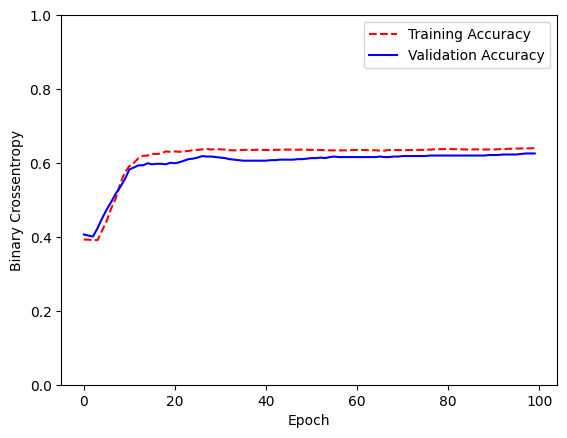

In [70]:
plot_history(history)

## 6. Validación del modelo con los datos de test


In [83]:
test_loss, test_acc = model.evaluate(normed_test_data,  test_labels)
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6180 - loss: 0.6581 
Test accuracy: 60.40%
Test loss: 0.666
